In [1]:
import pandas as pd
import numpy as np
import requests
import json
import time
import os 
import gzip
import timeit

from scripts.vectology_functions import create_aaa_distances, create_pair_distances, embed_text, encode_traits, create_efo_nxo


#!pip install pandas-profiling[notebook]==2.10.1
from pandas_profiling import ProfileReport

#from ontoma import OnToma
#otmap = OnToma()

import seaborn as sns

# Apply the default theme
sns.set_theme()

In [2]:
# globals
ebi_data = 'data/UK_Biobank_master_file.tsv'
#efo_nodes = 'data/efo-nodes.tsv'
#efo_data = 'data/efo_data.txt.gz'
efo_nodes = 'data/epigraphdb_efo_nodes.csv'
efo_rels = 'data/epigraphdb_efo_rels.csv'
nxontology_measure = 'batet'

modelData = [
    {'name':'BioSentVec','model':'BioSentVec'},
    {'name':'BioBERT','model':'biobert_v1.1_pubmed'},
    {'name':'BlueBERT','model':'NCBI_BERT_pubmed_mimic_uncased_L-12_H-768_A-12'},
    {'name':'GUSE','model':'GUSEv4'},
    {'name':'BERT-EFO','model':'BERT-EFO'},
    {'name':'Zooma','model':'Zooma'}
]

pallete="hls"
output='output/trait-efo'

In [17]:
# get the EBI UKB data
#get ebi data
#url='https://raw.githubusercontent.com/EBISPOT/EFO-UKB-mappings/master/UK_Biobank_master_file.tsv'
#ebi_df = pd.read_csv(url,sep='\t')

ebi_df = pd.read_csv(ebi_data,sep='\t')

#drop some columns
ebi_df = ebi_df[['ZOOMA QUERY','MAPPED_TERM_LABEL','MAPPED_TERM_URI','MAPPING_TYPE']]
ebi_df.rename(columns={'ZOOMA QUERY':'query'},inplace=True)
print(ebi_df.head())
print(ebi_df.shape)

#create new rows for multiple labels
#ebi_df = (
#        ebi_df.assign(label=ebi_df.MAPPED_TERM_LABEL.str.split("\|\|"))
#        .explode("label")
#        .reset_index(drop=True).drop('MAPPED_TERM_LABEL',axis=1)
#    )

#create new rows for multiple ids
ebi_df['MAPPED_TERM_URI']=ebi_df['MAPPED_TERM_URI'].str.replace('\|\|',',')
ebi_df['MAPPED_TERM_URI']=ebi_df['MAPPED_TERM_URI'].str.replace('\|',',')
ebi_df = (
        ebi_df.assign(id=ebi_df.MAPPED_TERM_URI.str.split(","))
        .explode("id")
        .reset_index(drop=True).drop('MAPPED_TERM_URI',axis=1)
    )

#clean up
ebi_df['id'] = ebi_df['id'].str.strip()

#remove underscores
ebi_df['query'] = ebi_df['query'].str.replace('_',' ')

#drop where query and id are duplicates
ebi_df.drop_duplicates(subset=['query','id'],inplace=True)
print(ebi_df.shape)

#drop nan
ebi_df.dropna(inplace=True)
print(ebi_df.shape)
print(ebi_df.head())

#drop cases where query and matched text are identical
print(ebi_df.shape)
ebi_df=ebi_df[ebi_df['query'].str.lower()!=ebi_df['MAPPED_TERM_LABEL'].str.lower()]
print(ebi_df.shape)

# add index as ID
ebi_df['mapping_id']=range(0,ebi_df.shape[0])
print(ebi_df.head())

# get counts of mapping type
print(ebi_df['MAPPING_TYPE'].value_counts())



                                      query       MAPPED_TERM_LABEL  \
0           Vascular disorders of intestine        vascular disease   
1                              Gonarthrosis  osteoarthritis || knee   
2  Psoriatic and enteropathic arthropathies     psoriatic arthritis   
3          Pain associated with micturition                 dysuria   
4                                Other mood           mood disorder   

            MAPPED_TERM_URI MAPPING_TYPE  
0  EFO_0004264, EFO_0009431        Broad  
1               EFO_0004616        Broad  
2               EFO_0003778      ? Broad  
3               EFO_0003901      ? Broad  
4               EFO_0004247      ? Broad  
(1565, 4)
(1612, 4)
(1598, 4)
                                      query       MAPPED_TERM_LABEL  \
0           Vascular disorders of intestine        vascular disease   
1           Vascular disorders of intestine        vascular disease   
2                              Gonarthrosis  osteoarthritis || knee   
3

In [18]:
%%time

# get EFO node data
efo_node_df = pd.read_csv(efo_nodes)
efo_node_df.rename(columns={'efo.value':'efo_label','efo.id':'efo_id'},inplace=True)
#drop type
efo_node_df.drop('efo.type',inplace=True,axis=1)
efo_node_df.drop_duplicates(inplace=True)
print(efo_node_df)

                                      efo_label  \
0                 Xeroderma pigmentosum variant   
1                         Xeroderma pigmentosum   
2                               Ischemic stroke   
3                             Cerebral ischemia   
4                          small cell carcinoma   
...                                         ...   
25385         Acetazolamide-responsive myotonia   
25386  Complete androgen insensitivity syndrome   
25387                Intermediate DEND syndrome   
25388                              Epiblepharon   
25389              Congenital eyelid retraction   

                                          efo_id  
0       http://www.orpha.net/ORDO/Orphanet_90342  
1         http://www.orpha.net/ORDO/Orphanet_910  
2      http://purl.obolibrary.org/obo/HP_0002140  
3      http://purl.obolibrary.org/obo/HP_0002637  
4           http://www.ebi.ac.uk/efo/EFO_0008524  
...                                          ...  
25385   http://www.orpha.net/O

In [19]:
%%time

#check all terms in EBI data set are in EFO node data
efo_node_ids = list(efo_node_df['efo_id'])
ebi_ids = list(ebi_df['id'])
missing=[]
matched = []
for i in ebi_ids:
    match = False
    for s in efo_node_ids:
        if i in s and match == False:
            matched.append(s)
            match = True
    if match == False:
        missing.append(i)
print('Missing:',len(missing))

# remove missing from ukb data
print(ebi_df.shape)
for i in missing:
    ebi_df = ebi_df.drop(ebi_df[ebi_df['id'].str.contains(i)].index)
ebi_df['full_id'] = matched
print(ebi_df.head())
print(ebi_df.shape)
ebi_df.to_csv('output/ebi-ukb-cleaned.tsv',index=False,sep='\t')


Missing: 19
(1320, 5)
                                      query       MAPPED_TERM_LABEL  \
0           Vascular disorders of intestine        vascular disease   
1           Vascular disorders of intestine        vascular disease   
2                              Gonarthrosis  osteoarthritis || knee   
3  Psoriatic and enteropathic arthropathies     psoriatic arthritis   
4          Pain associated with micturition                 dysuria   

  MAPPING_TYPE           id  mapping_id                               full_id  
0        Broad  EFO_0004264           0  http://www.ebi.ac.uk/efo/EFO_0004264  
1        Broad  EFO_0009431           1  http://www.ebi.ac.uk/efo/EFO_0009431  
2        Broad  EFO_0004616           2  http://www.ebi.ac.uk/efo/EFO_0004616  
3      ? Broad  EFO_0003778           3  http://www.ebi.ac.uk/efo/EFO_0003778  
4      ? Broad  EFO_0003901           4  http://www.ebi.ac.uk/efo/EFO_0003901  
(1301, 6)
CPU times: user 3.63 s, sys: 22.6 ms, total: 3.65 s
Wall time

In [ ]:
# preprocess
# doesn't really need doing
def preprocess():
    process_text=[]
    for k,g in ebi_df.groupby(np.arange(len(ebi_df))//20):
        params={'text_list':list(g['query'])}
        process_res = requests.post('http://vectology-api.mrcieu.ac.uk/preprocess',data=json.dumps(params))
        process_text.extend([d['result'].replace('unspecified','').replace('nec','') for d in process_res.json()])
    print(len(process_text))
        
    ebi_df.loc[:, 'processed'] = process_text
    print(ebi_df.head())

In [20]:
%%time

# encode the EBI query terms with Vectology models
queries = list(ebi_df['query'])
chunk=10

vectology_models = ['BioSentVec','BioBERT','BlueBERT']

for m in modelData:
    name = m['name']
    model = m['model']
    if name in vectology_models: 
        f = f"output/{m['name']}-ebi-encode.npy"
        if os.path.exists(f):
            print(name,'done')
        else:
            print('Encoding EBI queriues with',model)
            results=[]
            for i in range(0,len(queries),chunk):
                if i % 100 == 0:
                    print(i)
                batch = queries[i:i+chunk]
                #print('\n',i,queries[i:i+chunk])
                res = embed_text(textList=batch,model=model)
                for r in res:
                    results.append(r)
            print('Results',len(results))
            np.save(f,results)


Encoding EBI queriues with BioSentVec
0
100
200
300
400
500
600
700
800
900
1000
1100
1200
1300
Results 1301
Encoding EBI queriues with biobert_v1.1_pubmed
0
100
200
300
400
500
600
700
800
900
1000
1100
1200
1300
Results 1301
Encoding EBI queriues with NCBI_BERT_pubmed_mimic_uncased_L-12_H-768_A-12
0
100
200
300
400
500
600
700
800
900
1000
1100
1200
1300
Results 1301
CPU times: user 4.8 s, sys: 1.14 s, total: 5.94 s
Wall time: 5min 23s


In [45]:
%%time

# encode the EFO query terms with Vectology models
queries = list(efo_node_df['efo_label'])
chunk=20

vectology_models = ['BioSentVec','BioBERT','BlueBERT']

for m in modelData:
    name = m['name']
    model = m['model']
    if name in vectology_models: 
        f = f"output/{m['name']}-efo-encode.npy"
        if os.path.exists(f):
            print(name,'done')
        else:
            print('Encoding EFO queriues with',model)
            results=[]
            for i in range(0,len(queries),chunk):
                if i % 100 == 0:
                    print(i)
                batch = queries[i:i+chunk]
                #print('\n',i,queries[i:i+chunk])
                res = embed_text(textList=batch,model=model)
                for r in res:
                    results.append(r)
            print('Results',len(results))
            np.save(f,results)

BioSentVec done
Encoding EFO queriues with biobert_v1.1_pubmed
0
100
200
300
400
500
600
700
800
900
1000
1100
1200
1300
1400
1500
1600
1700
1800
1900
2000
2100
2200
2300
2400
2500
2600
2700
2800
2900
3000
3100
3200
3300
3400
3500
3600
3700
3800
3900
4000
4100
4200
4300
4400
4500
4600
4700
4800
4900
5000
5100
5200
5300
5400
5500
5600
5700
5800
5900
6000
6100
6200
6300
6400
6500
6600
6700
6800
6900
7000
7100
7200
7300
7400
7500
7600
7700
7800
7900
8000
8100
8200
8300
8400
8500
8600
8700
8800
8900
9000
9100
9200
9300
9400
9500
9600
9700
9800
9900
10000
10100
10200
10300
10400
10500
10600
10700
10800
10900
11000
11100
11200
11300
11400
11500
11600
11700
11800
11900
12000
12100
12200
12300
12400
12500
12600
12700
12800
12900
13000
13100
13200
13300
13400
13500
13600
13700
13800
13900
14000
14100
14200
14300
14400
14500
14600
14700
14800
14900
15000
15100
15200
15300
15400
15500
15600
15700
15800
15900
16000
16100
16200
16300
16400
16500
16600
16700
16800
16900
17000
17100
17200
17300
17400

In [21]:
%%time

# Google Universal Sentence Encoder

#!pip install  "tensorflow>=2.0.0"
#!pip install  --upgrade tensorflow-hub

import tensorflow_hub as hub

embed = hub.load("https://tfhub.dev/google/universal-sentence-encoder/4")

CPU times: user 25.4 s, sys: 10.9 s, total: 36.3 s
Wall time: 10min 5s


In [22]:
%%time

# create GUSE encodings for EBI and EFO

guse_ebi_embeddings = embed(ebi_df['query'])
guse_efo_embeddings = embed(efo_node_df['efo_label'])

guse_ebi_embeddings_list = []
for g in guse_ebi_embeddings:
    guse_ebi_embeddings_list.append(g.numpy())
np.save(f'output/GUSE-ebi-encode.npy',guse_ebi_embeddings_list)
#ebi_df['GUSE']=guse_ebi_embeddings_list

guse_efo_embeddings_list = []
for g in guse_efo_embeddings:
    guse_efo_embeddings_list.append(g.numpy())
np.save('output/GUSE-efo-encode.npy',guse_efo_embeddings_list)
#efo_df['GUSE']=guse_efo_embeddings_list

print(ebi_df.head())

#print(len(guse_ebi_embeddings), guse_ebi_embeddings[0].numpy())
#print(len(guse_efo_embeddings), guse_efo_embeddings[0].numpy().shape)
#guse_corr = np.inner(guse_ebi_embeddings, guse_efo_embeddings)

#print(len(corr[0]))
#np.save('output/guse-dd.npy',guse_corr)
#a=np.load('output/guse-dd.npy')
#print(len(a))

# add to ebi_df
#ebi_df['guse']=guse_ebi_embeddings
#print(ebi_df.head())

                                      query       MAPPED_TERM_LABEL  \
0           Vascular disorders of intestine        vascular disease   
1           Vascular disorders of intestine        vascular disease   
2                              Gonarthrosis  osteoarthritis || knee   
3  Psoriatic and enteropathic arthropathies     psoriatic arthritis   
4          Pain associated with micturition                 dysuria   

  MAPPING_TYPE           id  mapping_id                               full_id  
0        Broad  EFO_0004264           0  http://www.ebi.ac.uk/efo/EFO_0004264  
1        Broad  EFO_0009431           1  http://www.ebi.ac.uk/efo/EFO_0009431  
2        Broad  EFO_0004616           2  http://www.ebi.ac.uk/efo/EFO_0004616  
3      ? Broad  EFO_0003778           3  http://www.ebi.ac.uk/efo/EFO_0003778  
4      ? Broad  EFO_0003901           4  http://www.ebi.ac.uk/efo/EFO_0003901  
CPU times: user 7.13 s, sys: 1.48 s, total: 8.61 s
Wall time: 6.7 s


In [23]:
%%time

#create nxontology network of EFO relationships
efo_rel_df=pd.read_csv(efo_rels)
efo_nx = create_efo_nxo(df=efo_rel_df,child_col='efo.id',parent_col='parent_efo.id')
efo_nx.freeze()

CPU times: user 4.14 s, sys: 403 ms, total: 4.54 s
Wall time: 4.58 s


In [54]:
def run_pairs(model):
    dd_name = f"{output}/{model}-dd.npy"
    
    #v1 = list(ebi_df[model])
    #v2 = list(efo_df[model])
    if os.path.exists(f'output/{model}-ebi-encode.npy'):
        v1 = np.load(f'output/{model}-ebi-encode.npy')
        v2 = np.load(f'output/{model}-efo-encode.npy')
        
        if os.path.exists(dd_name):
            print(dd_name,'already created, loading...')
            with open(dd_name, 'rb') as f:
                dd = np.load(f)
        else:    
            # cosine of lists
            dd = create_pair_distances(v1,v2)
            np.save(dd_name,dd)
        print('done')
        return dd

def write_to_file(model_name,pairwise_data):
    print('writing',model_name)
    f = f'{output}/{model_name}-pairwise.tsv.gz'
    if os.path.exists(f):
        print('Already done',f)
    else:
        fo = gzip.open(f,'w')
        fo.write("mapping_id\tmanual\tprediction\tscore\n".encode('utf-8'))
        ebi_efo_list = list(ebi_df['full_id'])
        efo_list = list(efo_node_df['efo_id'])
        for i in range(0,len(ebi_efo_list)):
            if i % 100 == 0:
                print(i)
            # write to file
            mCount=0
            for j in range(i,len(efo_list)):
                if i != j:
                    #print(ids[i],ids[j],1-pws[mCount])
                    score = 1-pairwise_data[i][j]
                    fo.write(f"{i}\t{ebi_efo_list[i]}\t{efo_list[j]}\t{score}\n".encode('utf-8'))
                    mCount+=1

# all this can be done with pairwise data so ignore this function              
def get_top(model,pairwise_data):
    count=0
    dis_results=[]
    efo_map = []
    cosine_results = []
    manual_pos_results = []
    for manual_efo in ebi_df['full_id']:
        predicted_efo = None
        #min_val = 0
        min_val=None
        manual_dis_loc=None
        nx_val=None
        cosine_val=None
        
        #skip encodings with just zeros
        if np.count_nonzero(ebi_df.iloc[count][model])>0:
            #print('Empty encoding',ebi_df.iloc[count][model])
            
            # find the EFO term with minumum distance
            min_dis = np.nanargmin(pairwise_data[count])
            min_val = np.nanmin(pairwise_data[count])
            cosine_val = 1-min_val

            predicted_efo = efo_df.iloc[min_dis]['efo_id']
            #efo_map.append(predicted_efo)

            # find the location of the 'correct' EFO term and get ordered position 
            manual_loc = efo_df[efo_df['efo_id'] == manual_efo].index[0]
            manual_dis = pairwise_data[count][manual_loc]
            
            #print(manual_dis)
            # create sorted list of cosines to find position of manual mapped EFO
            # deal with nan too
            sorted_dis = sorted([x for x in pairwise_data[count] if str(x) != 'nan'])
            manual_dis_loc = sorted_dis.index(manual_dis)
            

            #run nxontology similarity
            res = similarity = efo_nx.similarity(manual_efo,predicted_efo).results()
            nx_val = res[nxontology_measure]
            
        manual_pos_results.append(manual_dis_loc)
        dis_results.append(nx_val)    
        cosine_results.append(cosine_val)
        efo_map.append(predicted_efo)
        count+=1
        
    ebi_df[f'{model}-nx']=dis_results
    ebi_df[f'{model}-efo']=efo_map
    ebi_df[f'{model}-cosine']=cosine_results
    ebi_df[f'{model}-rank']=manual_pos_results
    #print(ebi_df.head())
    print(model,'greater than 0.9:',ebi_df[ebi_df[f'{model}-nx']>0.9].shape)
    
    #plot histogram of distances
    sns_plot = sns.displot(ebi_df, x=f"{model}-nx",kde=True)
    sns_plot.savefig(f"{output}/{model}-{nxontology_measure}-nx.pdf")
    
    #plot correlation between cosine and nxontolgy
    sns_rel = sns.relplot(data=ebi_df, x=f'{model}-nx', y=f'{model}-cosine')
    sns_rel.savefig(f"{output}/{model}-nx-vs-cosine.pdf")
    
    #plot histogram of correct EFO location
    sns_plot = sns.displot(ebi_df, x=f"{model}-rank", kind='kde', cut=0, palette=pallete, height=6, cumulative=True,common_norm=False)
    sns_plot.savefig(f"{output}/{model}-rank.pdf")

#dd = run_pairs('BioSentVec')
#get_top('BioSentVec',dd)
#for m in modelData:
#    dd = run_pairs(m['name'])
#    get_top(m['name'],dd)    

#print(ebi_df.head())

In [55]:
%%time

#dd = run_pairs('BioSentVec')
#get_top('BioSentVec',dd)

#get_top('BioSentVec',dd)

for m in modelData:
    print(m['name'])
    dd = run_pairs(m['name'])
    if dd is not None:
        #get_top(m['name'],dd)   
        write_to_file(model_name=m['name'],pairwise_data=dd) 
    else:
        print(m['name'],'not done')

BioSentVec
output/trait-efo/BioSentVec-dd.npy already created, loading...
done
writing BioSentVec
0
100
200
300
400
500
600
700
800
900
1000
1100
1200
1300
BioBERT
output/trait-efo/BioBERT-dd.npy already created, loading...
done
writing BioBERT
0
100
200
300
400
500
600
700
800
900
1000
1100
1200
1300
BlueBERT
output/trait-efo/BlueBERT-dd.npy already created, loading...
done
writing BlueBERT
0
100
200
300
400
500
600
700
800
900
1000
1100
1200
1300
GUSE
output/trait-efo/GUSE-dd.npy already created, loading...
done
writing GUSE
0
100
200
300
400
500
600
700
800
900
1000
1100
1200
1300
BERT-EFO
BERT-EFO not done
Zooma
Zooma not done
CPU times: user 24min 23s, sys: 11.5 s, total: 24min 35s
Wall time: 24min 52s


In [ ]:
# ontoma 
# print(otmap.find_term('Vascular disorders of intestine'))
# think this is just using zooma

In [47]:
a = np.load('output/BioBERT-ebi-encode.npy')
b = np.load('output/BioBERT-efo-encode.npy')
c = np.load('output/BioSentVec-ebi-encode.npy')
d = np.load('output/BioSentVec-efo-encode.npy')
print(a.shape)
print(b.shape)
print(c.shape)
print(d.shape)

(1301, 768)
(25390, 768)
(1301, 700)
(25390, 700)


In [6]:
# zooma using API
def run_zooma(text):
    zooma_api = 'https://www.ebi.ac.uk/spot/zooma/v2/api/services/annotate'
    payload = {
        'propertyValue':text,
        'filter':'required:[none],ontologies:[efo]'
    }
    res = requests.get(zooma_api,params=payload).json()
    if res:
        #print(res[0]['confidence'])
        #print(text,res[0]['semanticTags'])
        efo = res[0]['semanticTags'][0]
        confidence = res[0]['confidence']
        return {'query':text,'prediction':efo.strip(),'confidence':confidence.strip()}
    else:
        return {'query':text,'prediction':'NA','confidence':'NA'}

In [15]:
%%time

# takes around 3 minutes for 1,000
f=f'{output}/zooma.tsv'
if os.path.exists('aa'):
    print('Zooma done')
else:
    all_res = []
    count=0
    for q in list(ebi_df['query']):
        res = run_zooma(q)
        res['mapping_id']=count
        all_res.append(res)
        print(res)
        count+=1
    #print(list(res))
    df = pd.DataFrame(all_res)
    #df['manual'] = ebi_df['full_id'][0:5] 
    #df['mapping_id'] = ebi_df['mapping_id'][0:5]
    print(df.head())
    #df = pd.merge(df,ebi_df,left_on='query',right_on='query')
    print(df.shape)
    #df[['mapping_id','manual','prediction','confidence']].to_csv(f,index=False,sep='\t')
    df.to_csv(f,index=False,sep='\t')

pping_id': 1169}
{'query': 'Postprocedural disorders of genito-urinary system, not elsewhere classified', 'prediction': 'http://www.ebi.ac.uk/efo/EFO_0000540', 'confidence': 'MEDIUM', 'mapping_id': 1170}
{'query': 'Other arthrosis', 'prediction': 'http://www.ebi.ac.uk/efo/EFO_0002506', 'confidence': 'GOOD', 'mapping_id': 1171}
{'query': 'Acquired deformities of fingers and toes', 'prediction': 'http://www.orpha.net/ORDO/Orphanet_357332', 'confidence': 'MEDIUM', 'mapping_id': 1172}
{'query': 'Other acquired deformities of limbs', 'prediction': 'http://www.orpha.net/ORDO/Orphanet_294944', 'confidence': 'MEDIUM', 'mapping_id': 1173}
{'query': 'Disorders of patella', 'prediction': 'http://www.ebi.ac.uk/efo/EFO_0009665', 'confidence': 'GOOD', 'mapping_id': 1174}
{'query': 'Other specific joint derangements', 'prediction': 'http://www.ebi.ac.uk/efo/EFO_0000706', 'confidence': 'GOOD', 'mapping_id': 1175}
{'query': 'Other systemic involvement of connective tissue', 'prediction': 'http://purl.o

In [ ]:
#print(zooma_df.head())

# merge with ebi file
#m = pd.merge(zooma_df,ebi_df,left_on='PROPERTY VALUE',right_on='query')
#m.drop_duplicates(inplace=True)
#print(m.head())
#print(m.shape)

dis_results=[]
efo_results=[]
df = pd.read_csv(f'{output}/zooma.tsv',sep='\t')
for i, row in df.iterrows():
    try:
        res = similarity = efo_nx.similarity(row['prediction'],row['manual']).results()
        dis_results.append(res[nxontology_measure])
    except:
        dis_results.append(0)
        
print(len(dis_results))
df['score'] = dis_results
print(df[df['score']>0.9].shape)
df.to_csv(f'{output}/zooma-pairwise-filter.tsv.gz',sep='\t',index=False,compression='gzip')
sns.displot(df, x="score",kde=True)

In [ ]:
# BERT-EFO

def bert_efo():
    bef_df = pd.read_csv('data/bluebert_efo_mapping.csv')
    bef_df.rename(columns={'efo_id':'BERT-EFO-efo'},inplace=True)
    print(bef_df.head())
    print(bef_df.shape)

    # merge with ebi_df
    ebi_df_merge = pd.merge(ebi_df,bef_df,left_on='query',right_on='ukbb_trait')
    print(ebi_df_merge.head())

    dis_results=[]
    name = 'BERT-EFO-nx'
    for i, row in ebi_df_merge.iterrows():
        res = similarity = efo_nx.similarity(row['BERT-EFO-efo'],row['full_id']).results()
        dis_results.append(res[nxontology_measure])


    print(len(dis_results))
    ebi_df_merge[name] = dis_results
    print(ebi_df_merge.head())
    print(ebi_df_merge[ebi_df_merge['BERT-EFO-nx']>0.9].shape)
    ebi_df_merge.to_csv('{output}/ebi-nx.tsv',sep='\t',index=False)
    sns.displot(ebi_df_merge, x=name,kde=True)
    return ebi_df_merge
ebi_df_merge=bert_efo()
print(ebi_df_merge.shape)

In [ ]:
print(ebi_df_merge.shape)
def add_bert_ranks():
    df = pd.read_csv('data/bluebert_efo_rankings.csv')
    print(df.head())
    m = pd.merge(ebi_df_merge,df[['ukbb_trait','ranking']],left_on='ukbb_trait',right_on='ukbb_trait')
    m.rename(columns={'ranking':'BERT-EFO-rank'},inplace=True)
    print(m.head())
    return m
ebi_df_merge = add_bert_ranks()
print(ebi_df_merge.shape)
ebi_df_merge.drop_duplicates(subset=['query','full_id'],inplace=True)
print(ebi_df_merge.shape)

In [ ]:
# compare the methods
# which values does BioSentVec map but zooma does not?

#bb1 = ebi_df_merge[(ebi_df['BioSentVec-nx']==1) & (ebi_df_merge['Zooma-nx']<0.8)]
#print(bb1.shape)

#bb2 = ebi_df_merge[(ebi_df['Zooma-nx']==1) & (ebi_df_merge['BioSentVec-nx']<0.8)]
#print(bb2[['query','MAPPED_TERM_LABEL','full_id','BioSentVec-nx','BioSentVec-efo']])

In [ ]:
print(ebi_df_merge[ebi_df_merge['BERT-EFO-nx']==1].shape)
print(ebi_df_merge[ebi_df_merge['BioSentVec-nx']==1].shape)
print(ebi_df.describe())

In [ ]:
# melt data for plots
#ebi_df_merge = ebi_df
#print(ebi_df_merge.head())

print(ebi_df_merge.describe())
print(ebi_df_merge.shape)
nx_list = ['BioSentVec-nx','BlueBERT-nx','BioBERT-nx','Zooma-nx','BERT-EFO-nx','GUSE-nx']

#ebi_df_merge.reset_index(inplace=True)
print(ebi_df_merge.head())
ebi_df_melt = pd.melt(ebi_df_merge, id_vars=['query'], value_vars=nx_list)
#ebi_df_melt = pd.melt(ebi_df_merge, id_vars=['query'], value_vars=['BioSentVec-nx','BlueBERT-nx','BioBERT-nx','Zooma-nx'])
ebi_df_melt.rename(columns={'variable':'Model'},inplace=True)
#print(ebi_df_melt.head())


# violin plot
#ax = sns.violinplot(x="variable", y="value", inner='quartile', data=ebi_df_melt, cut=0)
#ax.set_title('EFO distance', fontsize=16);
#fig = ax.get_figure()
#fig.savefig(f"output/all-nx.pdf")

plot_kind="kde"
ax = sns.displot(x="value", hue="Model", data=ebi_df_melt, kind=plot_kind, cut=0, palette=pallete, height=6)
#ax = sns.displot(x="value", hue="Model", data=ebi_df_melt, kind=plot_kind, palette=pallete, height=6,kde=True,stat='density')
ax.set(xlabel=f'nxontology score ({nxontology_measure})', ylabel=plot_kind)
ax.savefig(f"{output}/all-nx-{plot_kind}.pdf")

In [ ]:
# clustermap
#g = sns.clustermap(ebi_df_merge[nx_list])
#g.savefig('{output}/clustermap.pdf')

In [ ]:
# pandas profiling
profile = ProfileReport(ebi_df_merge, title="Pandas Profiling Report")
#profile.to_widgets()
profile.to_notebook_iframe()

In [ ]:
# general metrics

def describe_and_plot(df,col_list,name):
    describe_df = df[col_list].describe()
    describe_df.drop(['count','max'],inplace=True)
    describe_df.reset_index(inplace=True)
    print(describe_df)
    describe_df_melt = pd.melt(describe_df, id_vars = ['index'])

    g = sns.catplot(
        data=describe_df_melt, kind="bar",
        x="index", y="value", hue="variable",
         palette=pallete, height=6
    )
    g.despine(left=True)
    g.set_axis_labels("", name)
    g.legend.set_title("")
    g.savefig(f'{output}/{name}-describe.pdf')
    
describe_and_plot(ebi_df_merge,nx_list,'nxontology')
ranking_list = ['BioSentVec-rank','BlueBERT-rank','BioBERT-rank','BERT-EFO-rank','GUSE-rank']
describe_and_plot(ebi_df_merge,ranking_list,'ranking')

In [ ]:
ebi_df_ranking_melt = pd.melt(ebi_df_merge, id_vars=['query'], value_vars=ranking_list)
ebi_df_ranking_melt.rename(columns={'variable':'Model'},inplace=True)
print(ebi_df_ranking_melt.head())

# violin
#ax = sns.violinplot(x="variable", y="value", inner='quartile', data=ebi_df_ranking_melt, cut=0)
#ax.set_title('EFO ranking position', fontsize=16);
#ax.set_yscale("log")
#ax.set_xticklabels(ax.get_xticklabels(), rotation=30)
#fig = ax.get_figure()

# density
ax = sns.displot(x="value", hue="Model", data=ebi_df_ranking_melt, kind='kde', cut=0, palette=pallete, height=6, cumulative=True,common_norm=False)
#ax = sns.kdeplot(x="value", hue="Model", data=ebi_df_ranking_melt, cut=0, palette=pallete, cumulative=True)
#ax = sns.displot(x="value", hue="Model", data=ebi_df_melt, kind=plot_kind, palette=pallete, height=6,kde=True,stat='density')
#ax.set(xlabel=f'ranking distance', ylabel=plot_kind).set(xscale ='log')
ax.set(xlabel=f'ranking distance', ylabel=plot_kind)
#ax.set_xscale("log")
ax.savefig(f"{output}/all-ranking-kde.pdf")


In [ ]:
# check some things
# number of nx value of 1 for each model
#print(modelData)
#print(ebi_df_merge.shape)
#print(ebi_df_merge.head())
ebi_df_merge = ebi_df_merge.drop_duplicates(subset=['query','id'])
print(ebi_df_merge.shape)
topSummary = []
for m in modelData:
    mName = f"{m['name']}-nx"
    if mName in ebi_df_merge:
        ##print(m)
        nx1 = ebi_df_merge[ebi_df_merge[mName]>0.9].shape[0]/ebi_df.shape[0]
        if f"{m['name']}-rank" in ebi_df_merge:
            ranking10 = ebi_df_merge[ebi_df_merge[f"{m['name']}-rank"]<10].shape[0]/ebi_df.shape[0]
        else:
            ranking10 = None
        topSummary.append({'name':m['name'],'nx1':nx1,'ranking10':ranking10})
    else:
        print(m['name'],'missing')
print(topSummary)
df = pd.DataFrame(topSummary)
print(df.head())

def plot_summary(df):
    df_melt = pd.melt(df, id_vars = ['name'])
    print(df_melt)

    g = sns.catplot(
        data=df_melt, kind="bar",
        x="variable", y="value", hue="name",
            palette=pallete, height=6
    )
    g.despine(left=True)
    #g.set_axis_labels("", name)
    g.legend.set_title("")
    g.savefig(f'{output}/nx-ranking-summary.pdf')
plot_summary(df)


In [ ]:
# find cases for each model where all other models don't map well
#print(modelData)

for i in modelData:
    fName = f"{i['name']}-nx"
    if fName in ebi_df_merge:
        d = ebi_df_merge[ebi_df_merge[fName]>0.9]
        for j in modelData:
            if i != j:
                # find hits not matched with other models
                fNameFilt = f"{j['name']}-nx"
                d = d[d[fNameFilt]<0.5]        
    else:
        print(m['name'], 'not in df')
    print(fName,d.shape[0],'\n',d['query'],'\n')

In [ ]:
# find cases where no model mapped correctly
d = ebi_df_merge
cols = ['query','full_id']
for i in modelData:
    fName = f"{i['name']}-nx"
    d = d[d[fName]<1]
    cols.append(f"{i['name']}-nx")
    cols.append(f"{i['name']}-efo")
print(d.shape[0],'\n',d[cols],'\n')   

# nx distances for each model for missing values, i.e. which one was closest

In [80]:
%%time

top_x = 100

def filter_paiwise_file(model_name):
    print('filter_pairwise_file',model_name)
    f = f"{output}/{model_name}-pairwise-filter.tsv.gz"
    if os.path.exists(f):
        print('Already done',model_name)
        return
    else:
        try:
            df = pd.read_csv(f"{output}/{model_name}-pairwise.tsv.gz",sep='\t')
            print(df.shape)
            df = df.sort_values(by=['score'],ascending=False).groupby('mapping_id').head(top_x)
            print(df.shape)
            df.sort_values(by=['mapping_id','score'],ascending=[True,False]).to_csv(f,sep='\t',index=False,compression='gzip')
        except:
            print('Error',model_name)
            return

def filter_bert():
    df = pd.read_csv(f"data/efo_mk1_inference_top100_no_underscores.csv.gz")
    df_top = df.sort_values(by=['score']).groupby('text_1').head(top_x)
    df_top = pd.merge(df_top,ebi_df[['query','full_id']],left_on='text_1',right_on='query')
    df_top.rename(columns={'full_id':'manual'},inplace=True)
    df_top.drop('query',axis=1,inplace=True)

    #map to predicted EFO
    df_top = pd.merge(df_top,efo_node_df,left_on='text_2',right_on='efo_label')
    df_top.rename(columns={'efo_id':'prediction'},inplace=True)
    df_top.drop('efo_label',axis=1,inplace=True)
    print(df_top.head())
    df_top[['manual','prediction','score']].sort_values(by=['manual','score']).to_csv(f'{output}/BERT-EFO-pairwise-filter.tsv.gz',index=False,compression='gzip',sep='\t')
    print(df_top.head())

def get_top_using_pairwise_file(model_name,top_num):
    f = f"{output}/{model_name}-top-{top_num}.tsv"
    if os.path.exists(f):
        print('Top done',model_name)
    else:
        print('Reading',model_name)
        try:
            df = pd.read_csv(f"{output}/{model_name}-pairwise-filter.tsv.gz",sep='\t')
        except:
            print('Data do not exist for',model_name)
            return
        print(df.head())
        print(df.shape)
        top_res = []
        manual_efos = list(ebi_df['full_id'])
        for i in range(0,len(manual_efos)):
        #for i in range(0,10):
            manual_efo = manual_efos[i]
           # print(i,manual_efo)
            efo_predictions = df[df['manual']==manual_efo].head(n=top_num)[['prediction','score']]
            #end = time.time()
            #print(end-start)
            #print(efo_predictions)
            # run nxontolog for each
            for j,row in efo_predictions.iterrows():
                predicted_efo = row['prediction']
                score = row['score']
                #print(predicted_efo,score)
                res = similarity = efo_nx.similarity(manual_efo,predicted_efo).results()
                nx_val = res[nxontology_measure]
                top_res.append({'mapping_id':i,'manual':manual_efo,'prediction':predicted_efo,'score':score,'nx':nx_val})  
                #print(f"manual: {manual_efo} predicted: {predicted_efo} score: {score} nx: {nx_val}")
        res_df = pd.DataFrame(top_res)
        res_df.to_csv(f,index=False)

filter_bert()
for m in modelData:
    filter_paiwise_file(model_name=m['name'])
    get_top_using_pairwise_file(model_name=m['name'],top_num=100)



                                      text_1         text_2     score  \
0                              Hyperhidrosis  hyperhidrosis -1.336845   
1  Bring up phlegm/sputum/mucus on most days  hyperhidrosis  3.923928   
2                      ovarian cyst or cysts  hyperhidrosis  4.505346   
3                               Pneumothorax  hyperhidrosis  4.344087   
4                        tinnitus / tiniitis  hyperhidrosis  4.338106   

                                      manual  \
0       http://www.ebi.ac.uk/efo/EFO_1000712   
1       http://www.ebi.ac.uk/efo/EFO_0009824   
2  http://purl.obolibrary.org/obo/HP_0000138   
3  http://purl.obolibrary.org/obo/HP_0002108   
4  http://purl.obolibrary.org/obo/HP_0000360   

                                  prediction  
0  http://purl.obolibrary.org/obo/HP_0000975  
1  http://purl.obolibrary.org/obo/HP_0000975  
2  http://purl.obolibrary.org/obo/HP_0000975  
3  http://purl.obolibrary.org/obo/HP_0000975  
4  http://purl.obolibrary.org/obo/HP_

output/trait-efo/BioSentVec-top-100.tsv
659
output/trait-efo/BioBERT-top-100.tsv
659
output/trait-efo/BlueBERT-top-100.tsv
659
output/trait-efo/GUSE-top-100.tsv
659
output/trait-efo/BERT-EFO-top-100.tsv
659
output/trait-efo/Zooma-top-100.tsv
Data do not exist for Zooma


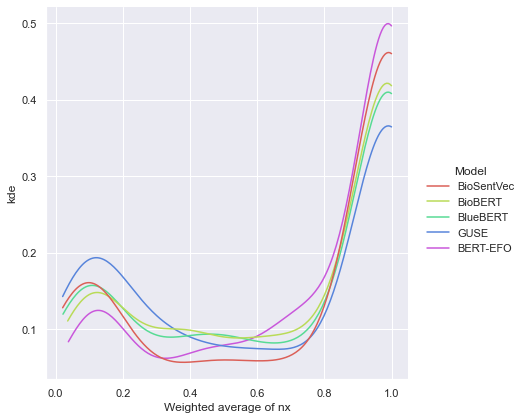

In [81]:
# calculate weighted average

def calc_weighted_average(model_name,top_num,mapping_types):
    f = f"{output}/{model_name}-top-100.tsv"
    print(f)
    res = []
    try:
        df = pd.read_csv(f,sep=',')
        #print(df.head())
    except:
        print('Data do not exist for',model_name)
        return
    manual_efos = list(ebi_df['full_id'])
    for i in range(0,len(manual_efos)):
        manual_efo = manual_efos[i]
        #filter on type
        mapping_type = ebi_df[ebi_df['full_id']==manual_efo]['MAPPING_TYPE'].values[0]
        #print(mapping_type)
        if mapping_type in mapping_types:
            #print(i,manual_efo)
            nx_scores = list(df[df['manual']==manual_efo].head(n=top_num)['nx'])
            weights = list(reversed(range(1,(len(nx_scores)+1))))
            #print(model_name,manual_efo,nx_scores,weights)
            weighted_avg = round(np.average( nx_scores, weights = weights),3)
            res.append(weighted_avg)
            #print(nx_scores,weights,weighted_avg)
    print(len(res))
    return res

#res = calc_weighted_average('BioSentVec',5)

all_res = {}
top_nums=[1,2,5,10,20,50,100]
#top_nums=[1]

def run(mapping_types,mapping_name):
    for top_num in top_nums:
        for m in modelData:
            res = calc_weighted_average(m['name'],top_num,mapping_types)
            if res is not None:
                all_res[m['name']]=res

        df = pd.DataFrame(all_res)
        df['efo'] = ebi_df['full_id']
        #print(df.head())
        df_melt = pd.melt(df, id_vars=['efo'])
        df_melt.rename(columns={'variable':'Model'},inplace=True)
        #print(df_melt.head())
        #ax = sns.displot(x="value", hue="Model", data=df_melt, kind='kde', cut=0, palette=pallete, height=6, cumulative=True,common_norm=False)
        ax = sns.displot(x="value", hue="Model", data=df_melt, kind='kde', cut=0, palette=pallete, height=6,common_norm=True)
        #sns_plot = sns.displot(ebi_df, x=f"{model}-nx",kde=True)
        ax.set(xlabel=f'Weighted average of nx', ylabel='kde')
        #ax.set_xscale("log")
        ax.savefig(f"{output}/weighted-average-nx-{top_num}-{mapping_name}.pdf")

run(mapping_types=['Exact','Broad','Narrow'],mapping_name='all')
run(mapping_types=['Exact'],mapping_name='exact')
run(mapping_types=['Broad','Narrow'],mapping_name='broad-narrow')
